Synthesizing [adversarial examples](https://arxiv.org/abs/1312.6199) for neural networks is surprisingly easy: small, carefully-crafted perturbations to inputs can cause neural networks to misclassify inputs in arbitrarily chosen ways. Given that adversarial examples [transfer to the physical world](https://arxiv.org/abs/1607.02533) and [can be made extremely robust](https://blog.openai.com/robust-adversarial-inputs/), this is a real security concern.

In this post, we give a brief introduction to algorithms for synthesizing adversarial examples, and we walk through the process of implementing attacks in [TensorFlow](https://www.tensorflow.org/), building up to synthesizing a robust adversarial example following [this technique](https://arxiv.org/abs/1707.07397).

**This post is an executable [Jupyter notebook](http://jupyter.org/): you're encouraged to [download it](/media/2017/07/25/adversarial.ipynb) and experiment with the examples yourself!**

# Setup

We choose to attack an [Inception v3](https://arxiv.org/abs/1512.00567) network trained on [ImageNet](http://www.image-net.org/). In this section, we load a pre-trained network from the [TF-slim image classification library](https://github.com/tensorflow/models/tree/master/slim). This part isn't particularly interesting, so **feel free to [skip this section](#adversarial-examples)**.

In [2]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
import tensorflow.contrib.slim.nets as nets

In [3]:
tf.logging.set_verbosity(tf.logging.ERROR)
sess = tf.InteractiveSession()

First, we set up the input image. We use a `tf.Variable` instead of a `tf.placeholder` because we will need it to be trainable. We can still feed it when we want to.

In [4]:
image = tf.Variable(tf.zeros((224, 224, 3)))

Next, we load the Inception v3 model.

In [5]:
def inception(image, reuse):
    preprocessed = tf.multiply(tf.subtract(tf.expand_dims(image, 0), 0.5), 2.0)
    arg_scope = nets.inception.inception_v1_arg_scope(weight_decay=0.0)
    with slim.arg_scope(arg_scope):
        logits, _ = nets.inception.inception_v1(
            preprocessed, 1001, is_training=False, reuse=reuse)
        logits = logits[:,1:] # ignore background class
        probs = tf.nn.softmax(logits) # probabilities
    return logits, probs

logits, probs = inception(image, reuse=False)

Next, we load pre-trained weights. This Inception v3 has a top-5 accuracy of 93.9%.

In [6]:
import tempfile
from urllib.request import urlretrieve
import tarfile
import os

In [7]:
data_dir = tempfile.mkdtemp()
inception_tarball, _ = urlretrieve(
    'http://download.tensorflow.org/models/inception_v1_2016_08_28.tar.gz')
tarfile.open(inception_tarball, 'r:gz').extractall(data_dir)

In [8]:
restore_vars = [
    var for var in tf.global_variables()
    if var.name.startswith('InceptionV1/')
]
saver = tf.train.Saver(restore_vars)
saver.restore(sess, os.path.join(data_dir, 'inception_v1.ckpt'))


Next, we write some code to show an image, classify it, and show the classification result.

In [9]:
import json
import matplotlib.pyplot as plt

In [10]:
imagenet_json, _ = urlretrieve(
    'http://www.anishathalye.com/media/2017/07/25/imagenet.json')
with open(imagenet_json) as f:
    imagenet_labels = json.load(f)

In [11]:
def classify(img, correct_class=None, target_class=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))
    fig.sca(ax1)
    p = sess.run(probs, feed_dict={image: img})[0]
    ax1.imshow(img)
    fig.sca(ax1)
    
    topk = list(p.argsort()[-10:][::-1])
    topprobs = p[topk]
    barlist = ax2.bar(range(10), topprobs)
    if target_class in topk:
        barlist[topk.index(target_class)].set_color('r')
    if correct_class in topk:
        barlist[topk.index(correct_class)].set_color('g')
    plt.sca(ax2)
    plt.ylim([0, 1.1])
    plt.xticks(range(10),
               [imagenet_labels[i][:15] for i in topk],
               rotation='vertical')
    fig.subplots_adjust(bottom=0.2)
    plt.show()

## Example image

We load our example image and make sure it's classified correctly.

In [12]:
import PIL
import numpy as np
from os import listdir

In [13]:
# Define our custom get_top_five
def get_top_five(path, img):
    # Get predictions
    p = sess.run(probs, feed_dict={image: img})[0]
    topk = list(p.argsort()[-10:][::-1])
    topprobs = p[topk]
    
    # Put results in nice list
    current_results = [path]
    for i in range(5):
        current_results.append('{}: probability: {:.02f}, label: {}'
              .format(i+1, topprobs[i], imagenet_labels[topk[i]]))

    # Legacy requires us to wrap the results in another empty list
    to_return = []
    to_return.append(current_results)
    return(to_return)

In [15]:
# Run across each dir and get the similar images predicitons
for advi in [5, 342, 773]:
    demo_target = advi # "guacamole"
    for file in sorted(listdir("/home/w266ajh/Documents/top5gen/data_imageparts_1/")):
        if not file.endswith('.jpg'): continue

        # Get image and write out the results
        img = PIL.Image.open("/home/w266ajh/Documents/top5gen/data_imageparts_1/" + file)
        big_dim = max(img.width, img.height)
        wide = img.width > img.height
        new_w = 224 if not wide else int(img.width * 224 / img.height)
        new_h = 224 if wide else int(img.height * 224 / img.width)
        img = img.resize((new_w, new_h)).crop((0, 0, 224, 224))
        img = (np.asarray(img) / 255.0).astype(np.float32)

        print(get_top_five("img_path", img))

        # Generate the adversarial ###
        x = tf.placeholder(tf.float32, (224, 224, 3))

        x_hat = image # our trainable adversarial input
        assign_op = tf.assign(x_hat, x)

        learning_rate = tf.placeholder(tf.float32, ())
        y_hat = tf.placeholder(tf.int32, ())

        labels = tf.one_hot(y_hat, 1000)
        loss = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=[labels])
        optim_step = tf.train.GradientDescentOptimizer(
            learning_rate).minimize(loss, var_list=[x_hat])

        epsilon = tf.placeholder(tf.float32, ())

        below = x - epsilon
        above = x + epsilon
        projected = tf.clip_by_value(tf.clip_by_value(x_hat, below, above), 0, 1)
        with tf.control_dependencies([projected]):
            project_step = tf.assign(x_hat, projected)

        demo_epsilon = 2.0/255.0 # a really small perturbation
        demo_lr = 1e-1
        demo_steps = 100

        # initialization step
        sess.run(assign_op, feed_dict={x: img})

        # projected gradient descent
        for i in range(demo_steps):
            # gradient descent step
            _, loss_value = sess.run(
                [optim_step, loss],
                feed_dict={learning_rate: demo_lr, y_hat: demo_target})
            # project step
            sess.run(project_step, feed_dict={x: img, epsilon: demo_epsilon})
            if (i+1) % 10 == 0:
                print('step %d, loss=%g' % (i+1, loss_value))


        adv = x_hat.eval() # retrieve the adversarial example
        from skimage.io import imsave
        imsave("adv_images/adv_" + file + "_" + str(advi) + ".png", adv, plugin='pil', format_str='png')

        ###

        # Get the adv prediction
        print(get_top_five("adv", adv))

[['img_path', '1: probability: 0.93, label: cheeseburger', '2: probability: 0.03, label: hotdog, hot dog, red hot', '3: probability: 0.01, label: bagel, beigel', '4: probability: 0.00, label: French loaf', '5: probability: 0.00, label: pretzel']]
step 10, loss=0.0745826
step 20, loss=0.0274223
step 30, loss=0.0193071
step 40, loss=0.0152627
step 50, loss=0.0128315
step 60, loss=0.0111517
step 70, loss=0.00996165
step 80, loss=0.00905573
step 90, loss=0.00833261
step 100, loss=0.00773743
[['adv', '1: probability: 0.99, label: electric ray, crampfish, numbfish, torpedo', '2: probability: 0.00, label: stingray', '3: probability: 0.00, label: snail', '4: probability: 0.00, label: mushroom', '5: probability: 0.00, label: puffer, pufferfish, blowfish, globefish']]
[['img_path', '1: probability: 0.94, label: cheeseburger', '2: probability: 0.01, label: meat loaf, meatloaf', '3: probability: 0.01, label: guacamole', '4: probability: 0.01, label: plate', '5: probability: 0.01, label: bagel, bei

/home/w266ajh/.local/lib/python3.6/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


step 10, loss=0.0132117
step 20, loss=0.00729208
step 30, loss=0.00526221
step 40, loss=0.00420389
step 50, loss=0.00352832
step 60, loss=0.00306209
step 70, loss=0.00272261
step 80, loss=0.00246103
step 90, loss=0.00225575
step 100, loss=0.00208601
[['adv', '1: probability: 1.00, label: electric ray, crampfish, numbfish, torpedo', '2: probability: 0.00, label: stingray', '3: probability: 0.00, label: Dungeness crab, Cancer magister', '4: probability: 0.00, label: rock crab, Cancer irroratus', '5: probability: 0.00, label: leatherback turtle, leatherback, leathery turtle, Dermochelys coriacea']]
[['img_path', '1: probability: 0.99, label: cheeseburger', '2: probability: 0.00, label: bagel, beigel', '3: probability: 0.00, label: guacamole', '4: probability: 0.00, label: hotdog, hot dog, red hot', '5: probability: 0.00, label: meat loaf, meatloaf']]
step 10, loss=1.81243
step 20, loss=0.0180097
step 30, loss=0.0111483
step 40, loss=0.00830151
step 50, loss=0.00672612
step 60, loss=0.0057

step 10, loss=0.0275213
step 20, loss=0.0154463
step 30, loss=0.0109831
step 40, loss=0.00869607
step 50, loss=0.007349
step 60, loss=0.00641584
step 70, loss=0.00573525
step 80, loss=0.00521786
step 90, loss=0.0048045
step 100, loss=0.0044643
[['adv', '1: probability: 1.00, label: electric ray, crampfish, numbfish, torpedo', '2: probability: 0.00, label: stingray', '3: probability: 0.00, label: jackfruit, jak, jack', '4: probability: 0.00, label: puffer, pufferfish, blowfish, globefish', '5: probability: 0.00, label: jellyfish']]
[['img_path', '1: probability: 1.00, label: jackfruit, jak, jack', '2: probability: 0.00, label: brain coral', '3: probability: 0.00, label: fig', '4: probability: 0.00, label: honeycomb', '5: probability: 0.00, label: bolete']]
step 10, loss=0.128636
step 20, loss=0.0641239
step 30, loss=0.0468678
step 40, loss=0.0376801
step 50, loss=0.0319771
step 60, loss=0.0281265
step 70, loss=0.0253552
step 80, loss=0.0231998
step 90, loss=0.0213685
step 100, loss=0.01

step 90, loss=0.00358047
step 100, loss=0.00329321
[['adv', '1: probability: 1.00, label: electric ray, crampfish, numbfish, torpedo', '2: probability: 0.00, label: stingray', '3: probability: 0.00, label: dugong, Dugong dugon', '4: probability: 0.00, label: eel', '5: probability: 0.00, label: sturgeon']]
[['img_path', '1: probability: 0.80, label: remote control, remote', '2: probability: 0.04, label: hand-held computer, hand-held microcomputer', '3: probability: 0.02, label: radio, wireless', '4: probability: 0.02, label: joystick', '5: probability: 0.01, label: CD player']]
step 10, loss=3.45501
step 20, loss=0.0631422
step 30, loss=0.0331374
step 40, loss=0.025025
step 50, loss=0.0207429
step 60, loss=0.0178617
step 70, loss=0.0159431
step 80, loss=0.0144625
step 90, loss=0.013347
step 100, loss=0.0124075
[['adv', '1: probability: 0.99, label: electric ray, crampfish, numbfish, torpedo', '2: probability: 0.00, label: stingray', '3: probability: 0.00, label: remote control, remote',

step 10, loss=4.92284
step 20, loss=3.80985
step 30, loss=3.3865
step 40, loss=3.30128
step 50, loss=3.06569
step 60, loss=2.92248
step 70, loss=2.77474
step 80, loss=2.66473
step 90, loss=2.55828
step 100, loss=2.72321
[['adv', '1: probability: 0.06, label: school bus', '2: probability: 0.06, label: crane', '3: probability: 0.06, label: electric ray, crampfish, numbfish, torpedo', '4: probability: 0.03, label: electric locomotive', '5: probability: 0.03, label: harvester, reaper']]
[['img_path', '1: probability: 1.00, label: school bus', '2: probability: 0.00, label: cab, hack, taxi, taxicab', '3: probability: 0.00, label: lifeboat', '4: probability: 0.00, label: trolleybus, trolley coach, trackless trolley', '5: probability: 0.00, label: passenger car, coach, carriage']]
step 10, loss=5.59547
step 20, loss=4.67821
step 30, loss=4.27725
step 40, loss=4.03782
step 50, loss=3.90623
step 60, loss=3.75982
step 70, loss=3.68144
step 80, loss=3.59541
step 90, loss=3.62649
step 100, loss=3.4

step 10, loss=0.271839
step 20, loss=0.0332087
step 30, loss=0.0222534
step 40, loss=0.0171354
step 50, loss=0.014111
step 60, loss=0.0120243
step 70, loss=0.0104545
step 80, loss=0.009283
step 90, loss=0.00842623
step 100, loss=0.00774736
[['adv', '1: probability: 0.99, label: electric ray, crampfish, numbfish, torpedo', '2: probability: 0.01, label: stingray', '3: probability: 0.00, label: submarine, pigboat, sub, U-boat', '4: probability: 0.00, label: pick, plectrum, plectron', '5: probability: 0.00, label: bullet train, bullet']]
[['img_path', '1: probability: 0.88, label: bullet train, bullet', '2: probability: 0.04, label: warplane, military plane', '3: probability: 0.01, label: wing', '4: probability: 0.01, label: projectile, missile', '5: probability: 0.01, label: bobsled, bobsleigh, bob']]
step 10, loss=0.0900337
step 20, loss=0.0401883
step 30, loss=0.0280329
step 40, loss=0.0220474
step 50, loss=0.0184511
step 60, loss=0.016066
step 70, loss=0.0142588
step 80, loss=0.0128774

step 10, loss=0.27683
step 20, loss=0.120228
step 30, loss=0.0860666
step 40, loss=0.070054
step 50, loss=0.0603055
step 60, loss=0.0541242
step 70, loss=0.0494258
step 80, loss=0.0456214
step 90, loss=0.0426967
step 100, loss=0.0399881
[['adv', '1: probability: 0.96, label: wild boar, boar, Sus scrofa', '2: probability: 0.03, label: hog, pig, grunter, squealer, Sus scrofa', '3: probability: 0.00, label: cheeseburger', '4: probability: 0.00, label: warthog', '5: probability: 0.00, label: puffer, pufferfish, blowfish, globefish']]
[['img_path', '1: probability: 0.87, label: colobus, colobus monkey', '2: probability: 0.02, label: gibbon, Hylobates lar', '3: probability: 0.00, label: guenon, guenon monkey', '4: probability: 0.00, label: langur', '5: probability: 0.00, label: giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca']]
step 10, loss=0.328617
step 20, loss=0.0577663
step 30, loss=0.043962
step 40, loss=0.0368685
step 50, loss=0.0321581
step 60, loss=0.028904
step 70

step 10, loss=0.44836
step 20, loss=0.0113554
step 30, loss=0.00471967
step 40, loss=0.00340323
step 50, loss=0.00275661
step 60, loss=0.00235732
step 70, loss=0.00207269
step 80, loss=0.00186032
step 90, loss=0.00170098
step 100, loss=0.00157816
[['adv', '1: probability: 1.00, label: wild boar, boar, Sus scrofa', '2: probability: 0.00, label: hog, pig, grunter, squealer, Sus scrofa', '3: probability: 0.00, label: warthog', '4: probability: 0.00, label: brown bear, bruin, Ursus arctos', '5: probability: 0.00, label: sloth bear, Melursus ursinus, Ursus ursinus']]
[['img_path', '1: probability: 0.98, label: nematode, nematode worm, roundworm', '2: probability: 0.01, label: vine snake', '3: probability: 0.00, label: sea snake', '4: probability: 0.00, label: hook, claw', '5: probability: 0.00, label: water snake']]
step 10, loss=3.51147
step 20, loss=0.801797
step 30, loss=0.854089
step 40, loss=0.00662808
step 50, loss=0.00395635
step 60, loss=0.00297105
step 70, loss=0.00244045
step 80, 

step 80, loss=0.0179098
step 90, loss=0.0162402
step 100, loss=0.0150956
[['adv', '1: probability: 0.99, label: wild boar, boar, Sus scrofa', '2: probability: 0.01, label: hog, pig, grunter, squealer, Sus scrofa', '3: probability: 0.00, label: warthog', '4: probability: 0.00, label: bobsled, bobsleigh, bob', '5: probability: 0.00, label: piggy bank, penny bank']]
[['img_path', '1: probability: 0.74, label: slide rule, slipstick', '2: probability: 0.14, label: rule, ruler', '3: probability: 0.02, label: oscilloscope, scope, cathode-ray oscilloscope, CRO', '4: probability: 0.02, label: radio, wireless', '5: probability: 0.02, label: scale, weighing machine']]
step 10, loss=3.69247
step 20, loss=1.28234
step 30, loss=0.170252
step 40, loss=0.121249
step 50, loss=0.0996067
step 60, loss=0.0862344
step 70, loss=0.0770786
step 80, loss=0.070392
step 90, loss=0.0657873
step 100, loss=0.0615891
[['adv', '1: probability: 0.94, label: wild boar, boar, Sus scrofa', '2: probability: 0.04, label: h

step 10, loss=3.84963
step 20, loss=1.85968
step 30, loss=0.0648372
step 40, loss=0.0426519
step 50, loss=0.0346963
step 60, loss=0.0302045
step 70, loss=0.0273126
step 80, loss=0.0249899
step 90, loss=0.023303
step 100, loss=0.0218854
[['adv', '1: probability: 0.98, label: wild boar, boar, Sus scrofa', '2: probability: 0.02, label: hog, pig, grunter, squealer, Sus scrofa', '3: probability: 0.00, label: warthog', '4: probability: 0.00, label: clog, geta, patten, sabot', '5: probability: 0.00, label: Irish wolfhound']]
[['img_path', '1: probability: 1.00, label: Christmas stocking', '2: probability: 0.00, label: sock', '3: probability: 0.00, label: mitten', '4: probability: 0.00, label: teddy, teddy bear', '5: probability: 0.00, label: pillow']]
step 10, loss=2.10798
step 20, loss=0.276797
step 30, loss=0.152195
step 40, loss=0.120543
step 50, loss=0.102721
step 60, loss=0.0909732
step 70, loss=0.0828929
step 80, loss=0.0769779
step 90, loss=0.0712581
step 100, loss=0.0675858
[['adv', '

step 10, loss=1.39274
step 20, loss=0.110347
step 30, loss=0.0706675
step 40, loss=0.0551031
step 50, loss=0.0464353
step 60, loss=0.0404164
step 70, loss=0.0360529
step 80, loss=0.0327112
step 90, loss=0.0300921
step 100, loss=0.0279558
[['adv', '1: probability: 0.97, label: wild boar, boar, Sus scrofa', '2: probability: 0.02, label: hog, pig, grunter, squealer, Sus scrofa', '3: probability: 0.00, label: mongoose', '4: probability: 0.00, label: weevil', '5: probability: 0.00, label: warthog']]
[['img_path', '1: probability: 0.98, label: weevil', '2: probability: 0.00, label: broccoli', '3: probability: 0.00, label: leaf beetle, chrysomelid', '4: probability: 0.00, label: dung beetle', '5: probability: 0.00, label: leafhopper']]
step 10, loss=0.133804
step 20, loss=0.0615233
step 30, loss=0.0437766
step 40, loss=0.0348237
step 50, loss=0.0289763
step 60, loss=0.0253547
step 70, loss=0.0225752
step 80, loss=0.0204599
step 90, loss=0.0188519
step 100, loss=0.017437
[['adv', '1: probabili

step 10, loss=0.396405
step 20, loss=0.0251096
step 30, loss=0.0160341
step 40, loss=0.0122459
step 50, loss=0.0100544
step 60, loss=0.00857363
step 70, loss=0.00753833
step 80, loss=0.00670292
step 90, loss=0.00606269
step 100, loss=0.00556965
[['adv', '1: probability: 0.99, label: saltshaker, salt shaker', '2: probability: 0.00, label: baboon', '3: probability: 0.00, label: teapot', '4: probability: 0.00, label: guenon, guenon monkey', '5: probability: 0.00, label: thimble']]
[['img_path', '1: probability: 0.97, label: colobus, colobus monkey', '2: probability: 0.01, label: guenon, guenon monkey', '3: probability: 0.00, label: gibbon, Hylobates lar', '4: probability: 0.00, label: langur', '5: probability: 0.00, label: indri, indris, Indri indri, Indri brevicaudatus']]
step 10, loss=0.248223
step 20, loss=0.0637384
step 30, loss=0.0441568
step 40, loss=0.0350706
step 50, loss=0.0299188
step 60, loss=0.026094
step 70, loss=0.0233638
step 80, loss=0.0212294
step 90, loss=0.0195261
step 

step 10, loss=0.00303962
step 20, loss=0.00153888
step 30, loss=0.00109065
step 40, loss=0.00086437
step 50, loss=0.000722981
step 60, loss=0.000627917
step 70, loss=0.000558816
step 80, loss=0.000504128
step 90, loss=0.000458374
step 100, loss=0.000419648
[['adv', '1: probability: 1.00, label: saltshaker, salt shaker', '2: probability: 0.00, label: thimble', '3: probability: 0.00, label: water bottle', '4: probability: 0.00, label: pop bottle, soda bottle', '5: probability: 0.00, label: piggy bank, penny bank']]
[['img_path', '1: probability: 0.97, label: remote control, remote', '2: probability: 0.01, label: dial telephone, dial phone', '3: probability: 0.00, label: cellular telephone, cellular phone, cellphone, cell, mobile phone', '4: probability: 0.00, label: microwave, microwave oven', '5: probability: 0.00, label: CD player']]
step 10, loss=0.0112571
step 20, loss=0.00574758
step 30, loss=0.00407532
step 40, loss=0.00324105
step 50, loss=0.00272522
step 60, loss=0.00235947
step 

step 100, loss=0.00157292
[['adv', '1: probability: 1.00, label: saltshaker, salt shaker', '2: probability: 0.00, label: soap dispenser', '3: probability: 0.00, label: perfume, essence', '4: probability: 0.00, label: thimble', '5: probability: 0.00, label: pill bottle']]
[['img_path', '1: probability: 1.00, label: school bus', '2: probability: 0.00, label: minibus', '3: probability: 0.00, label: trolleybus, trolley coach, trackless trolley', '4: probability: 0.00, label: passenger car, coach, carriage', '5: probability: 0.00, label: lifeboat']]
step 10, loss=4.1643
step 20, loss=3.23032
step 30, loss=2.66026
step 40, loss=2.52534
step 50, loss=2.37738
step 60, loss=2.18585
step 70, loss=1.99707
step 80, loss=2.09108
step 90, loss=1.91175
step 100, loss=1.8017
[['adv', '1: probability: 0.18, label: saltshaker, salt shaker', '2: probability: 0.15, label: school bus', '3: probability: 0.01, label: puck, hockey puck', '4: probability: 0.01, label: buckle', '5: probability: 0.01, label: min

step 80, loss=0.00354365
step 90, loss=0.00319554
step 100, loss=0.00291804
[['adv', '1: probability: 1.00, label: saltshaker, salt shaker', '2: probability: 0.00, label: soap dispenser', '3: probability: 0.00, label: piggy bank, penny bank', '4: probability: 0.00, label: thimble', '5: probability: 0.00, label: pitcher, ewer']]
[['img_path', '1: probability: 0.98, label: bullet train, bullet', '2: probability: 0.00, label: limousine, limo', '3: probability: 0.00, label: bobsled, bobsleigh, bob', '4: probability: 0.00, label: solar dish, solar collector, solar furnace', '5: probability: 0.00, label: convertible']]
step 10, loss=1.71041
step 20, loss=0.127244
step 30, loss=0.0773489
step 40, loss=0.0579388
step 50, loss=0.0471159
step 60, loss=0.0396474
step 70, loss=0.0339053
step 80, loss=0.0297562
step 90, loss=0.0265618
step 100, loss=0.0241202
[['adv', '1: probability: 0.98, label: saltshaker, salt shaker', '2: probability: 0.00, label: bullet train, bullet', '3: probability: 0.00, 

In [14]:
# Run across each dir and get the similar images predicitons
for advi in [5, 342, 773]:
    demo_target = advi # "guacamole"
    for file in sorted(listdir("/home/w266ajh/Documents/top5gen/data_imageparts/")):
        if not file.endswith('.jpg'): continue

        # Get image and write out the results
        img = PIL.Image.open("/home/w266ajh/Documents/top5gen/data_imageparts/" + file)
        big_dim = max(img.width, img.height)
        wide = img.width > img.height
        new_w = 224 if not wide else int(img.width * 224 / img.height)
        new_h = 224 if wide else int(img.height * 224 / img.width)
        img = img.resize((new_w, new_h)).crop((0, 0, 224, 224))
        img = (np.asarray(img) / 255.0).astype(np.float32)

        print(get_top_five("", img))

        # Generate the adversarial ###
        x = tf.placeholder(tf.float32, (224, 224, 3))

        x_hat = image # our trainable adversarial input
        assign_op = tf.assign(x_hat, x)

        learning_rate = tf.placeholder(tf.float32, ())
        y_hat = tf.placeholder(tf.int32, ())

        labels = tf.one_hot(y_hat, 1000)
        loss = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=[labels])
        optim_step = tf.train.GradientDescentOptimizer(
            learning_rate).minimize(loss, var_list=[x_hat])

        epsilon = tf.placeholder(tf.float32, ())

        below = x - epsilon
        above = x + epsilon
        projected = tf.clip_by_value(tf.clip_by_value(x_hat, below, above), 0, 1)
        with tf.control_dependencies([projected]):
            project_step = tf.assign(x_hat, projected)

        demo_epsilon = 2.0/255.0 # a really small perturbation
        demo_lr = 1e-1
        demo_steps = 100

        # initialization step
        sess.run(assign_op, feed_dict={x: img})

        # projected gradient descent
        for i in range(demo_steps):
            # gradient descent step
            _, loss_value = sess.run(
                [optim_step, loss],
                feed_dict={learning_rate: demo_lr, y_hat: demo_target})
            # project step
            sess.run(project_step, feed_dict={x: img, epsilon: demo_epsilon})
            if (i+1) % 10 == 0:
                print('step %d, loss=%g' % (i+1, loss_value))


        adv = x_hat.eval() # retrieve the adversarial example
        from skimage.io import imsave
        imsave("adv_images/adv_" + file + "_" + str(advi) + ".png", adv, plugin='pil', format_str='png')

        ###

        # Get the adv prediction
        print(get_top_five("adv", adv))

[['', '1: probability: 0.97, label: barn', '2: probability: 0.03, label: boathouse', '3: probability: 0.00, label: birdhouse', '4: probability: 0.00, label: church, church building', '5: probability: 0.00, label: lumbermill, sawmill']]
step 10, loss=5.66951
step 20, loss=3.52408
step 30, loss=1.21077
step 40, loss=0.421323
step 50, loss=0.285439
step 60, loss=0.23289
step 70, loss=0.20112
step 80, loss=0.183152
step 90, loss=0.170336
step 100, loss=0.160117


/home/w266ajh/.local/lib/python3.6/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


[['adv', '1: probability: 0.85, label: electric ray, crampfish, numbfish, torpedo', '2: probability: 0.04, label: stingray', '3: probability: 0.01, label: boathouse', '4: probability: 0.01, label: barn', '5: probability: 0.00, label: snail']]
[['', '1: probability: 0.98, label: barn', '2: probability: 0.01, label: boathouse', '3: probability: 0.00, label: church, church building', '4: probability: 0.00, label: thatch, thatched roof', '5: probability: 0.00, label: solar dish, solar collector, solar furnace']]
step 10, loss=2.403
step 20, loss=0.103727
step 30, loss=0.054339
step 40, loss=0.0412311
step 50, loss=0.0338264
step 60, loss=0.0293768
step 70, loss=0.026533
step 80, loss=0.0240503
step 90, loss=0.0221912
step 100, loss=0.0206803
[['adv', '1: probability: 0.98, label: electric ray, crampfish, numbfish, torpedo', '2: probability: 0.01, label: stingray', '3: probability: 0.00, label: barn', '4: probability: 0.00, label: tiger shark, Galeocerdo cuvieri', '5: probability: 0.00, lab

step 10, loss=0.01941
step 20, loss=0.00972368
step 30, loss=0.00685684
step 40, loss=0.00536004
step 50, loss=0.00443736
step 60, loss=0.00380115
step 70, loss=0.00332755
step 80, loss=0.00295441
step 90, loss=0.00266304
step 100, loss=0.00243118
[['adv', '1: probability: 1.00, label: electric ray, crampfish, numbfish, torpedo', '2: probability: 0.00, label: stingray', '3: probability: 0.00, label: jackfruit, jak, jack', '4: probability: 0.00, label: puffer, pufferfish, blowfish, globefish', '5: probability: 0.00, label: snail']]
[['', '1: probability: 0.92, label: refrigerator, icebox', '2: probability: 0.05, label: washer, automatic washer, washing machine', '3: probability: 0.01, label: safe', '4: probability: 0.00, label: photocopier', '5: probability: 0.00, label: dishwasher, dish washer, dishwashing machine']]
step 10, loss=1.90054
step 20, loss=0.0579397
step 30, loss=0.0348505
step 40, loss=0.0265588
step 50, loss=0.0217521
step 60, loss=0.0189774
step 70, loss=0.0170904
step 

step 10, loss=0.0188879
step 20, loss=0.0110044
step 30, loss=0.00823554
step 40, loss=0.00673489
step 50, loss=0.00573478
step 60, loss=0.00503071
step 70, loss=0.00448958
step 80, loss=0.00406618
step 90, loss=0.00371552
step 100, loss=0.0034283
[['adv', '1: probability: 1.00, label: electric ray, crampfish, numbfish, torpedo', '2: probability: 0.00, label: stingray', '3: probability: 0.00, label: puffer, pufferfish, blowfish, globefish', '4: probability: 0.00, label: brain coral', '5: probability: 0.00, label: tick']]
[['', '1: probability: 0.99, label: mashed potato', '2: probability: 0.01, label: cauliflower', '3: probability: 0.00, label: red wolf, maned wolf, Canis rufus, Canis niger', '4: probability: 0.00, label: meat loaf, meatloaf', '5: probability: 0.00, label: ice cream, icecream']]
step 10, loss=0.0109109
step 20, loss=0.00558424
step 30, loss=0.00410441
step 40, loss=0.00333218
step 50, loss=0.0028485
step 60, loss=0.00251144
step 70, loss=0.0022548
step 80, loss=0.00205

step 10, loss=0.197856
step 20, loss=0.0190812
step 30, loss=0.0125927
step 40, loss=0.00987797
step 50, loss=0.00823483
step 60, loss=0.00718403
step 70, loss=0.00641371
step 80, loss=0.00580921
step 90, loss=0.00532305
step 100, loss=0.00492562
[['adv', '1: probability: 1.00, label: electric ray, crampfish, numbfish, torpedo', '2: probability: 0.00, label: stingray', '3: probability: 0.00, label: sturgeon', '4: probability: 0.00, label: waffle iron', '5: probability: 0.00, label: dugong, Dugong dugon']]
[['', '1: probability: 0.83, label: Polaroid camera, Polaroid Land camera', '2: probability: 0.15, label: projector', '3: probability: 0.00, label: loudspeaker, speaker, speaker unit, loudspeaker system, speaker system', '4: probability: 0.00, label: CD player', '5: probability: 0.00, label: tape player']]
step 10, loss=2.00754
step 20, loss=0.0108072
step 30, loss=0.00686844
step 40, loss=0.00559882
step 50, loss=0.00485551
step 60, loss=0.0042998
step 70, loss=0.00388213
step 80, lo

step 10, loss=0.0792733
step 20, loss=0.0230033
step 30, loss=0.0159698
step 40, loss=0.0126817
step 50, loss=0.0106634
step 60, loss=0.00929268
step 70, loss=0.00828106
step 80, loss=0.00748366
step 90, loss=0.00685222
step 100, loss=0.00634252
[['adv', '1: probability: 0.99, label: electric ray, crampfish, numbfish, torpedo', '2: probability: 0.00, label: stingray', '3: probability: 0.00, label: gong, tam-tam', '4: probability: 0.00, label: toilet seat', '5: probability: 0.00, label: dial telephone, dial phone']]
[['', '1: probability: 1.00, label: dial telephone, dial phone', '2: probability: 0.00, label: pay-phone, pay-station', '3: probability: 0.00, label: iron, smoothing iron', '4: probability: 0.00, label: iPod', '5: probability: 0.00, label: hard disc, hard disk, fixed disk']]
step 10, loss=2.33434
step 20, loss=0.0571276
step 30, loss=0.0325447
step 40, loss=0.0242768
step 50, loss=0.0198911
step 60, loss=0.0171006
step 70, loss=0.0151791
step 80, loss=0.0137067
step 90, loss

step 60, loss=0.0773549
step 70, loss=0.0707369
step 80, loss=0.0655182
step 90, loss=0.0614327
step 100, loss=0.0579501
[['adv', '1: probability: 0.94, label: wild boar, boar, Sus scrofa', '2: probability: 0.03, label: hog, pig, grunter, squealer, Sus scrofa', '3: probability: 0.01, label: warthog', '4: probability: 0.00, label: wallaby, brush kangaroo', '5: probability: 0.00, label: mongoose']]
[['', '1: probability: 0.97, label: barn', '2: probability: 0.02, label: boathouse', '3: probability: 0.00, label: birdhouse', '4: probability: 0.00, label: thatch, thatched roof', '5: probability: 0.00, label: church, church building']]
step 10, loss=3.49462
step 20, loss=0.286009
step 30, loss=0.171772
step 40, loss=0.131582
step 50, loss=0.109759
step 60, loss=0.096395
step 70, loss=0.0867185
step 80, loss=0.0795973
step 90, loss=0.0740015
step 100, loss=0.0691112
[['adv', '1: probability: 0.93, label: wild boar, boar, Sus scrofa', '2: probability: 0.05, label: hog, pig, grunter, squealer, 

step 10, loss=2.36548
step 20, loss=0.520442
step 30, loss=0.145004
step 40, loss=0.0941275
step 50, loss=0.075975
step 60, loss=0.0637939
step 70, loss=0.0570299
step 80, loss=0.0513947
step 90, loss=0.0470562
step 100, loss=0.0434966
[['adv', '1: probability: 0.96, label: wild boar, boar, Sus scrofa', '2: probability: 0.03, label: hog, pig, grunter, squealer, Sus scrofa', '3: probability: 0.00, label: warthog', '4: probability: 0.00, label: puffer, pufferfish, blowfish, globefish', '5: probability: 0.00, label: stove']]
[['', '1: probability: 1.00, label: refrigerator, icebox', '2: probability: 0.00, label: vending machine', '3: probability: 0.00, label: medicine chest, medicine cabinet', '4: probability: 0.00, label: bakery, bakeshop, bakehouse', '5: probability: 0.00, label: confectionery, confectionary, candy store']]
step 10, loss=0.986769
step 20, loss=0.359512
step 30, loss=0.266896
step 40, loss=0.22311
step 50, loss=0.196232
step 60, loss=0.17667
step 70, loss=0.163295
step 8

step 10, loss=0.245494
step 20, loss=0.0731506
step 30, loss=0.0538773
step 40, loss=0.0437656
step 50, loss=0.0377904
step 60, loss=0.0337625
step 70, loss=0.0307041
step 80, loss=0.0283763
step 90, loss=0.0264834
step 100, loss=0.0249469
[['adv', '1: probability: 0.98, label: wild boar, boar, Sus scrofa', '2: probability: 0.02, label: hog, pig, grunter, squealer, Sus scrofa', '3: probability: 0.00, label: puffer, pufferfish, blowfish, globefish', '4: probability: 0.00, label: shovel', '5: probability: 0.00, label: mashed potato']]
[['', '1: probability: 0.99, label: mashed potato', '2: probability: 0.01, label: cauliflower', '3: probability: 0.00, label: dough', '4: probability: 0.00, label: ice cream, icecream', '5: probability: 0.00, label: red wolf, maned wolf, Canis rufus, Canis niger']]
step 10, loss=0.165766
step 20, loss=0.0480737
step 30, loss=0.034074
step 40, loss=0.027336
step 50, loss=0.023335
step 60, loss=0.0205328
step 70, loss=0.0183829
step 80, loss=0.0166973
step 90

step 10, loss=3.93187
step 20, loss=2.35845
step 30, loss=1.28606
step 40, loss=0.407906
step 50, loss=0.269373
step 60, loss=0.228292
step 70, loss=0.215749
step 80, loss=0.195203
step 90, loss=0.172432
step 100, loss=0.155933
[['adv', '1: probability: 0.86, label: wild boar, boar, Sus scrofa', '2: probability: 0.09, label: hog, pig, grunter, squealer, Sus scrofa', '3: probability: 0.01, label: warthog', '4: probability: 0.00, label: Polaroid camera, Polaroid Land camera', '5: probability: 0.00, label: wine bottle']]
[['', '1: probability: 0.96, label: Polaroid camera, Polaroid Land camera', '2: probability: 0.01, label: reflex camera', '3: probability: 0.00, label: projector', '4: probability: 0.00, label: espresso maker', '5: probability: 0.00, label: radio, wireless']]
step 10, loss=1.748
step 20, loss=0.23056
step 30, loss=0.140852
step 40, loss=0.10999
step 50, loss=0.0911728
step 60, loss=0.079293
step 70, loss=0.0710397
step 80, loss=0.0642212
step 90, loss=0.058489
step 100, l

step 10, loss=0.325463
step 20, loss=0.0981085
step 30, loss=0.0651996
step 40, loss=0.0505795
step 50, loss=0.0421344
step 60, loss=0.0362742
step 70, loss=0.0321659
step 80, loss=0.0291589
step 90, loss=0.0268858
step 100, loss=0.0249555
[['adv', '1: probability: 0.98, label: wild boar, boar, Sus scrofa', '2: probability: 0.01, label: hog, pig, grunter, squealer, Sus scrofa', '3: probability: 0.00, label: warthog', '4: probability: 0.00, label: dial telephone, dial phone', '5: probability: 0.00, label: cassette']]
[['', '1: probability: 0.99, label: dial telephone, dial phone', '2: probability: 0.00, label: vacuum, vacuum cleaner', '3: probability: 0.00, label: iron, smoothing iron', '4: probability: 0.00, label: oxygen mask', '5: probability: 0.00, label: pay-phone, pay-station']]
step 10, loss=0.276865
step 20, loss=0.0616044
step 30, loss=0.0450768
step 40, loss=0.0369774
step 50, loss=0.0318639
step 60, loss=0.0283412
step 70, loss=0.0257187
step 80, loss=0.0237061
step 90, loss=

step 10, loss=1.2354
step 20, loss=0.0326433
step 30, loss=0.0208698
step 40, loss=0.0157519
step 50, loss=0.012904
step 60, loss=0.0111009
step 70, loss=0.00979912
step 80, loss=0.00883137
step 90, loss=0.00808585
step 100, loss=0.00747384
[['adv', '1: probability: 0.99, label: saltshaker, salt shaker', '2: probability: 0.00, label: perfume, essence', '3: probability: 0.00, label: pop bottle, soda bottle', '4: probability: 0.00, label: thimble', '5: probability: 0.00, label: lighter, light, igniter, ignitor']]
[['', '1: probability: 0.98, label: dam, dike, dyke', '2: probability: 0.01, label: breakwater, groin, groyne, mole, bulwark, seawall, jetty', '3: probability: 0.00, label: pier', '4: probability: 0.00, label: dock, dockage, docking facility', '5: probability: 0.00, label: container ship, containership, container vessel']]
step 10, loss=0.254147
step 20, loss=0.0520734
step 30, loss=0.0319872
step 40, loss=0.0233269
step 50, loss=0.018748
step 60, loss=0.0158046
step 70, loss=0.

step 90, loss=0.0117428
step 100, loss=0.0108662
[['adv', '1: probability: 0.99, label: saltshaker, salt shaker', '2: probability: 0.00, label: thimble', '3: probability: 0.00, label: pop bottle, soda bottle', '4: probability: 0.00, label: confectionery, confectionary, candy store', '5: probability: 0.00, label: perfume, essence']]
[['', '1: probability: 1.00, label: gas pump, gasoline pump, petrol pump, island dispenser', '2: probability: 0.00, label: pay-phone, pay-station', '3: probability: 0.00, label: parking meter', '4: probability: 0.00, label: vending machine', '5: probability: 0.00, label: golfcart, golf cart']]
step 10, loss=0.0791183
step 20, loss=0.0286865
step 30, loss=0.0182351
step 40, loss=0.0138295
step 50, loss=0.0111006
step 60, loss=0.00923044
step 70, loss=0.00793424
step 80, loss=0.00696446
step 90, loss=0.00622311
step 100, loss=0.00562691
[['adv', '1: probability: 0.99, label: saltshaker, salt shaker', '2: probability: 0.00, label: lighter, light, igniter, ignit

step 60, loss=0.00368737
step 70, loss=0.00321526
step 80, loss=0.00285753
step 90, loss=0.00257363
step 100, loss=0.00234032
[['adv', '1: probability: 1.00, label: saltshaker, salt shaker', '2: probability: 0.00, label: puffer, pufferfish, blowfish, globefish', '3: probability: 0.00, label: piggy bank, penny bank', '4: probability: 0.00, label: eggnog', '5: probability: 0.00, label: Petri dish']]
[['', '1: probability: 0.46, label: steel arch bridge', '2: probability: 0.34, label: pier', '3: probability: 0.04, label: suspension bridge', '4: probability: 0.03, label: greenhouse, nursery, glasshouse', '5: probability: 0.02, label: crane']]
step 10, loss=0.829068
step 20, loss=0.0164473
step 30, loss=0.0102677
step 40, loss=0.008
step 50, loss=0.00662488
step 60, loss=0.00575327
step 70, loss=0.00512761
step 80, loss=0.00465346
step 90, loss=0.004296
step 100, loss=0.00397843
[['adv', '1: probability: 1.00, label: saltshaker, salt shaker', '2: probability: 0.00, label: candle, taper, wax

step 10, loss=0.0170649
step 20, loss=0.00904995
step 30, loss=0.00648963
step 40, loss=0.00522391
step 50, loss=0.00441481
step 60, loss=0.00382858
step 70, loss=0.00339943
step 80, loss=0.00307147
step 90, loss=0.00281189
step 100, loss=0.00259194
[['adv', '1: probability: 1.00, label: saltshaker, salt shaker', '2: probability: 0.00, label: piggy bank, penny bank', '3: probability: 0.00, label: soap dispenser', '4: probability: 0.00, label: pencil sharpener', '5: probability: 0.00, label: rubber eraser, rubber, pencil eraser']]
[['', '1: probability: 1.00, label: pencil sharpener', '2: probability: 0.00, label: washbasin, handbasin, washbowl, lavabo, wash-hand basin', '3: probability: 0.00, label: lighter, light, igniter, ignitor', '4: probability: 0.00, label: switch, electric switch, electrical switch', '5: probability: 0.00, label: combination lock']]
step 10, loss=0.031014
step 20, loss=0.0170205
step 30, loss=0.0123954
step 40, loss=0.0100361
step 50, loss=0.00854325
step 60, lo

step 90, loss=0.00162624
step 100, loss=0.00151341
[['adv', '1: probability: 1.00, label: saltshaker, salt shaker', '2: probability: 0.00, label: soap dispenser', '3: probability: 0.00, label: thimble', '4: probability: 0.00, label: pill bottle', '5: probability: 0.00, label: candle, taper, wax light']]
[['', '1: probability: 1.00, label: water tower', '2: probability: 0.00, label: balloon', '3: probability: 0.00, label: American black bear, black bear, Ursus americanus, Euarctos americanus', '4: probability: 0.00, label: radio telescope, radio reflector', '5: probability: 0.00, label: beacon, lighthouse, beacon light, pharos']]
step 10, loss=0.706651
step 20, loss=0.0130068
step 30, loss=0.00817974
step 40, loss=0.00640992
step 50, loss=0.00542442
step 60, loss=0.00477246
step 70, loss=0.00427843
step 80, loss=0.00391051
step 90, loss=0.00362264
step 100, loss=0.00338838
[['adv', '1: probability: 1.00, label: saltshaker, salt shaker', '2: probability: 0.00, label: thimble', '3: probab

In [12]:
img_path, _ = urlretrieve("file:///home/w266ajh/Documents/top5gen/data_imageparts_1/burger1.jpg") #urlretrieve('http://www.anishathalye.com/media/2017/07/25/cat.jpg')
img_class = 281
img = PIL.Image.open(img_path)
big_dim = max(img.width, img.height)
wide = img.width > img.height
new_w = 224 if not wide else int(img.width * 224 / img.height)
new_h = 224 if wide else int(img.height * 224 / img.width)
img = img.resize((new_w, new_h)).crop((0, 0, 224, 224))
img = (np.asarray(img) / 255.0).astype(np.float32)
with open("adv_input", "w") as out:
    out.write(str(img))

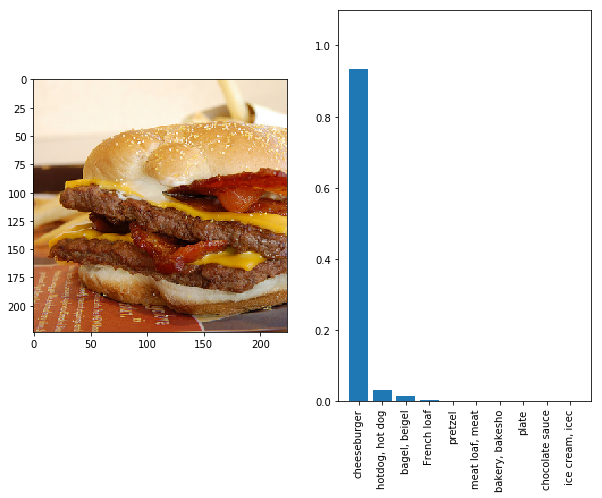

In [13]:
classify(img, correct_class=img_class)

# Adversarial examples

Given an image $\mathbf{x}$, our neural network outputs a probability distribution over labels, $P(y \mid \mathbf{x})$. When we craft an adversarial input, we want to find an $\hat{\mathbf{x}}$ where $\log P(\hat{y} \mid \hat{\mathbf{x}})$ is maximized for a target label $\hat{y}$: that way, our input will be misclassified as the target class. We can ensure that $\hat{\mathbf{x}}$ doesn't look too different from the original $\mathbf{x}$ by constraining ourselves to some $\ell_\infty$ box with radius $\epsilon$, requiring that $\left\lVert \mathbf{x} - \hat{\mathbf{x}} \right\rVert_\infty \le \epsilon$.

In this framework, an adversarial example is the solution to a constrained optimization problem that we can solve using [backpropagation](http://colah.github.io/posts/2015-08-Backprop/) and projected gradient descent, basically the same techniques that are used to train networks themselves. The algorithm is simple:

We begin by initializing our adversarial example as $\hat{\mathbf{x}} \leftarrow \mathbf{x}$. Then, we repeat the following until convergence:

1. $\hat{\mathbf{x}} \leftarrow \hat{\mathbf{x}} + \alpha \cdot \nabla \log P(\hat{y} \mid \hat{\mathbf{x}})$
2. $\hat{\mathbf{x}} \leftarrow \mathrm{clip}(\hat{\mathbf{x}}, \mathbf{x} - \epsilon, \mathbf{x} + \epsilon)$

## Initialization

We start with the easiest part: writing a TensorFlow op for initialization.

In [14]:
x = tf.placeholder(tf.float32, (224, 224, 3))

x_hat = image # our trainable adversarial input
assign_op = tf.assign(x_hat, x)

## Gradient descent step

Next, we write the gradient descent step to maximize the log probability of the target class (or equivalently, minimize the [cross entropy](https://en.wikipedia.org/wiki/Cross_entropy)).

In [15]:
learning_rate = tf.placeholder(tf.float32, ())
y_hat = tf.placeholder(tf.int32, ())

labels = tf.one_hot(y_hat, 1000)
loss = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=[labels])
optim_step = tf.train.GradientDescentOptimizer(
    learning_rate).minimize(loss, var_list=[x_hat])

## Projection step

Finally, we write the projection step to keep our adversarial example visually close to the original image. Additionally, we clip to $[0, 1]$ to keep it a valid image.

In [16]:
epsilon = tf.placeholder(tf.float32, ())

below = x - epsilon
above = x + epsilon
projected = tf.clip_by_value(tf.clip_by_value(x_hat, below, above), 0, 1)
with tf.control_dependencies([projected]):
    project_step = tf.assign(x_hat, projected)

## Execution

Finally, we're ready to synthesize an adversarial example. We arbitrarily choose "guacamole" (imagenet class 924) as our target class.

In [17]:
demo_epsilon = 2.0/255.0 # a really small perturbation
demo_lr = 1e-1
demo_steps = 100
demo_target = 5 # "guacamole"

# initialization step
sess.run(assign_op, feed_dict={x: img})

# projected gradient descent
for i in range(demo_steps):
    # gradient descent step
    _, loss_value = sess.run(
        [optim_step, loss],
        feed_dict={learning_rate: demo_lr, y_hat: demo_target})
    # project step
    sess.run(project_step, feed_dict={x: img, epsilon: demo_epsilon})
    if (i+1) % 10 == 0:
        print('step %d, loss=%g' % (i+1, loss_value))
    

adv = x_hat.eval() # retrieve the adversarial example
from skimage.io import imsave
imsave("adv.png", adv, plugin='pil', format_str='png')
# with open("adv_output.txt", 'w') as out:
#     out.write(str(a) for a in adv)
np.set_printoptions(threshold=np.nan)
with open("adv_output.txt", "w") as out:
    out.write(str(adv))

step 10, loss=0.0745826
step 20, loss=0.0274223
step 30, loss=0.0193071
step 40, loss=0.0152627
step 50, loss=0.0128315
step 60, loss=0.0111517
step 70, loss=0.00996165
step 80, loss=0.00905573
step 90, loss=0.00833261
step 100, loss=0.00773743


/home/w266ajh/.local/lib/python3.6/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


This adversarial image is visually indistinguishable from the original, with no visual artifacts. However, it's classified as "guacamole" with high probability!

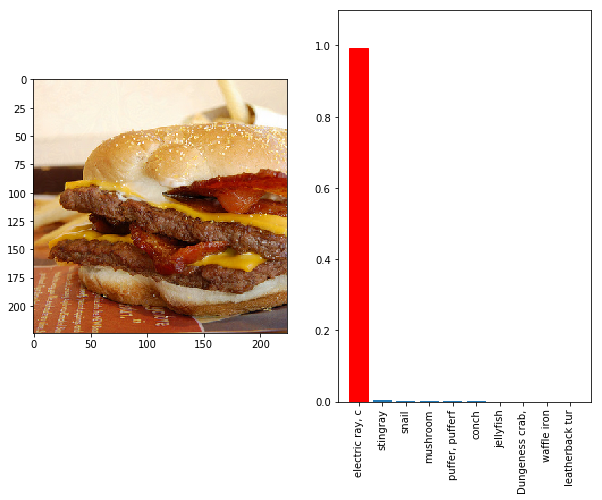

In [18]:
classify(adv, correct_class=img_class, target_class=demo_target)

# Robust adversarial examples

Now, we go through a more advanced example. We follow our approach for [synthesizing robust adversarial examples](https://arxiv.org/abs/1707.07397) to find a single perturbation of our cat image that's simultaneously adversarial under some chosen distribution of transformations.  We could choose any distribution of differentiable transformations; in this post, we'll synthesize a single adversarial input that's robust to rotation by $\theta \in [-\pi/4, \pi/4]$.

Before we proceed, let's check if our previous example is still adversarial if we rotate it, say by an angle of $\theta = \pi/8$.

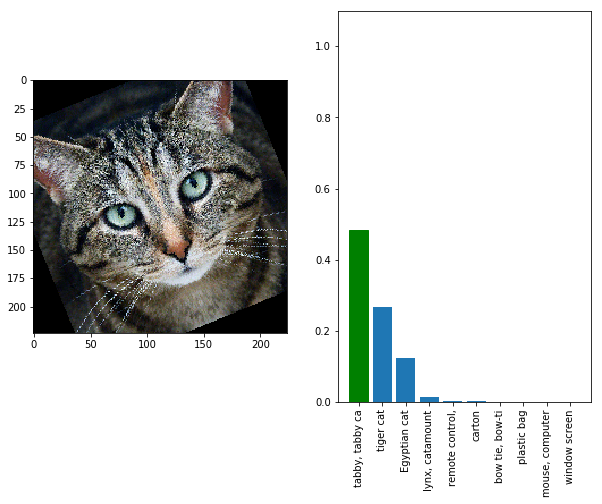

In [32]:
ex_angle = np.pi/8

angle = tf.placeholder(tf.float32, ())
rotated_image = tf.contrib.image.rotate(image, angle)
rotated_example = rotated_image.eval(feed_dict={image: adv, angle: ex_angle})
classify(rotated_example, correct_class=img_class, target_class=demo_target)

Looks like our original adversarial example is not rotation-invariant!

So, how do we make an adversarial example robust to a distribution of transformations? Given some distribution of transformations $T$, we can maximize $\mathbb{E}_{t \sim T} \log P\left(\hat{y} \mid t(\hat{\mathbf{x}})\right)$, subject to $\left\lVert \mathbf{x} - \hat{\mathbf{x}} \right\rVert_\infty \le \epsilon$. We can solve this optimization problem via projected gradient descent, noting that $\nabla \mathbb{E}_{t \sim T} \log P\left(\hat{y} \mid t(\hat{\mathbf{x}})\right)$ is $\mathbb{E}_{t \sim T} \nabla \log P\left(\hat{y} \mid t(\hat{\mathbf{x}})\right)$ and approximating with samples at each gradient descent step.

Rather than manually implementing the gradient sampling, we can use a trick to get TensorFlow to do it for us: we can model our sampling-based gradient descent as doing gradient descent over an ensemble of stochastic classifiers that randomly sample from the distribution and transform their input before classifying it.

In [33]:
num_samples = 10
average_loss = 0
for i in range(num_samples):
    rotated = tf.contrib.image.rotate(
        image, tf.random_uniform((), minval=-np.pi/4, maxval=np.pi/4))
    rotated_logits, _ = inception(rotated, reuse=True)
    average_loss += tf.nn.softmax_cross_entropy_with_logits(
        logits=rotated_logits, labels=labels) / num_samples

We can reuse our `assign_op` and `project_step`, though we'll have to write a new `optim_step` for this new objective.

In [34]:
optim_step = tf.train.GradientDescentOptimizer(
    learning_rate).minimize(average_loss, var_list=[x_hat])

Finally, we're ready to run PGD to generate our adversarial input. As in the previous example, we'll choose "guacamole" as our target class.

In [35]:
demo_epsilon = 8.0/255.0 # still a pretty small perturbation
demo_lr = 2e-1
demo_steps = 300
demo_target = 924 # "guacamole"

# initialization step
sess.run(assign_op, feed_dict={x: img})

# projected gradient descent
for i in range(demo_steps):
    # gradient descent step
    _, loss_value = sess.run(
        [optim_step, average_loss],
        feed_dict={learning_rate: demo_lr, y_hat: demo_target})
    # project step
    sess.run(project_step, feed_dict={x: img, epsilon: demo_epsilon})
    if (i+1) % 50 == 0:
        print('step %d, loss=%g' % (i+1, loss_value))
    

adv_robust = x_hat.eval() # retrieve the adversarial example

step 50, loss=4.92575
step 100, loss=3.15049
step 150, loss=0.332409
step 200, loss=0.066395
step 250, loss=0.0516987
step 300, loss=0.0207874


In [36]:
from skimage.io import imsave
imsave("adv_robust.png", adv_robust, plugin='pil', format_str='png')

/home/w266ajh/.local/lib/python3.6/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


This adversarial image is classified as "guacamole" with high confidence, even when it's rotated!

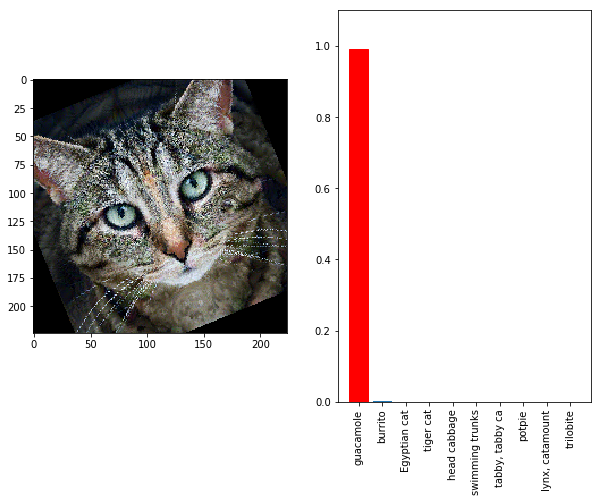

In [37]:
rotated_example = rotated_image.eval(feed_dict={image: adv_robust, angle: ex_angle})
classify(rotated_example, correct_class=img_class, target_class=demo_target)

## Evaluation

Let's examine the rotation-invariance of the robust adversarial example we produced over the entire range of angles, looking at $P(\hat{y} \mid \hat{\mathbf{x}})$ over $\theta \in [-\pi/4, \pi/4]$.

In [47]:
thetas = np.linspace(-np.pi/4, np.pi/4, 301)

p_naive = []
p_robust = []
for theta in thetas:
    rotated = rotated_image.eval(feed_dict={image: adv_robust, angle: theta})
    p_robust.append(probs.eval(feed_dict={image: rotated})[0][demo_target])
    
    rotated = rotated_image.eval(feed_dict={image: adv, angle: theta})
    p_naive.append(probs.eval(feed_dict={image: rotated})[0][demo_target])

robust_line, = plt.plot(thetas, p_robust, color='b', linewidth=2, label='robust')
naive_line, = plt.plot(thetas, p_naive, color='r', linewidth=2, label='naive')
plt.ylim([0, 1.05])
plt.xlabel('rotation angle')
plt.ylabel('target class probability')
plt.legend(handles=[robust_line, naive_line], loc='lower right')
plt.show()

NameError: name 'rotated_image' is not defined

It's super effective!